In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
from IPython.display import Image, display
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import DataConversionWarning
import matplotlib.pyplot as plt
import os
import sys
import multiprocessing as mp
import warnings
from pathlib import Path
warnings.filterwarnings("ignore", category=DataConversionWarning)

# Set File Paths for our image directory

In [2]:
base_path = Path().resolve()
path = os.path.join(base_path, 'dogs')
path_pre_transform = os.path.join(base_path, 'dogs_pre_transform')
path_compressed = os.path.join(base_path, 'dogs_compressed')
path_post_transform = os.path.join(base_path, 'dogs_post_transform')
path_figures = os.path.join(base_path, 'figures')

# Create a dictionary of images and convert to YUV (Y component only) form

In [3]:
im_dict = {}
old_size_dict = {}
for f in os.listdir(path):
    img = cv2.imread(os.path.join(path,f))
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    y, u, v = cv2.split(img_yuv)
    cv2.imwrite(os.path.join(path_pre_transform,  f) , y)
    old_size_dict.update({f: os.path.getsize(os.path.join(path_pre_transform, f))})
    im_dict.update({f : y})

# Define a helper function to scale features and perform PCA on an image then return its reconstructed form

In [4]:
def transform_images(f, X, var_frac):
    pipeline = Pipeline([('scaler',StandardScaler()), ('pca', PCA(var_frac))])
    compressed_img = pipeline.fit_transform(X)
    num_features = compressed_img.shape[1]
    return f, pipeline, compressed_img, pipeline.inverse_transform(compressed_img), num_features, var_frac

In [5]:
pool = mp.Pool(mp.cpu_count())

# Perform the PCA across several targets for variance explained

In [6]:
arg_list = []
for var_frac in [0.75, 0.9, 0.95, 0.99]:
    for f, X in im_dict.items():
        arg_list += [(f, X, var_frac)]
results = pool.starmap(transform_images, arg_list)

# Write the results to a file

In [7]:
size_dict = []
for f, model, compressed_img, img, n, v in results:
    new_f = str(v)+'_' +str(n)+'_'+f
    cv2.imwrite(os.path.join(path_compressed, new_f) , compressed_img)
    cv2.imwrite(os.path.join(path_post_transform, new_f), img)
    new_size = os.path.getsize(os.path.join(path_compressed, new_f)) + os.path.getsize(os.path.join(path_compressed, new_f))
    new_size += 4*np.sqrt(img.shape[0]**2 + img.shape[1]**2) # size of the eigen vectors needed to project PC's onto the original image space
    size_dict.append({'name' : f, 
                      'num features' : n, 
                      'var explained' : v, 
                      'old size' : old_size_dict[f], 
                      'new size' : new_size})

In [8]:
sizes_df = pd.DataFrame(size_dict).sort_values(['name', 'var explained'])
sizes_df['size ratio'] = sizes_df['new size']/sizes_df['old size']

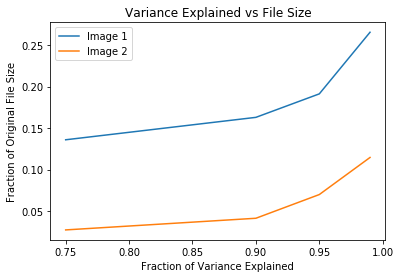

In [9]:
plt.plot(sizes_df.loc[sizes_df['name']=='dog3.jpg', 'var explained'].values, sizes_df.loc[sizes_df['name']=='dog3.jpg', 'size ratio'].values, label='Image 1')
plt.plot(sizes_df.loc[sizes_df['name']=='dog4.jpg', 'var explained'].values, sizes_df.loc[sizes_df['name']=='dog4.jpg','size ratio'].values, label='Image 2')
plt.xlabel('Fraction of Variance Explained')
plt.ylabel('Fraction of Original File Size')
plt.title('Variance Explained vs File Size')
plt.legend(loc='upper left')
plt.savefig(os.path.join(path_figures, 'Variance Explained vs File Size.jpg'))
plt.show()

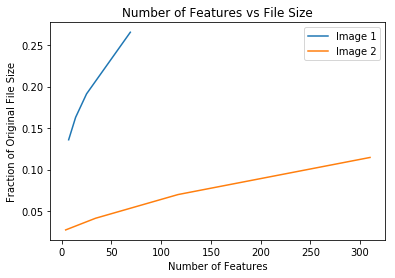

In [10]:
plt.plot(sizes_df.loc[sizes_df['name']=='dog3.jpg', 'num features'].values, sizes_df.loc[sizes_df['name']=='dog3.jpg', 'size ratio'].values, label='Image 1')
plt.plot(sizes_df.loc[sizes_df['name']=='dog4.jpg', 'num features'].values, sizes_df.loc[sizes_df['name']=='dog4.jpg','size ratio'].values, label='Image 2')
plt.xlabel('Number of Features')
plt.ylabel('Fraction of Original File Size')
plt.title('Number of Features vs File Size')
plt.legend(loc='upper right')
plt.savefig(os.path.join(path_figures, 'Number of Features vs File Size.jpg'))
plt.show()

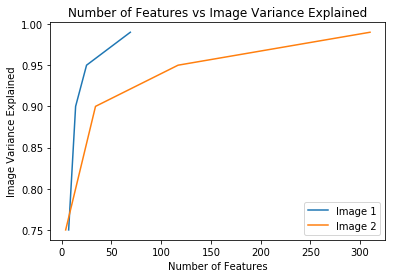

In [13]:
plt.plot(sizes_df.loc[sizes_df['name']=='dog3.jpg', 'num features'].values, sizes_df.loc[sizes_df['name']=='dog3.jpg', 'var explained'].values, label='Image 1')
plt.plot(sizes_df.loc[sizes_df['name']=='dog4.jpg', 'num features'].values, sizes_df.loc[sizes_df['name']=='dog4.jpg','var explained'].values, label='Image 2')
plt.xlabel('Number of Features')
plt.ylabel('Image Variance Explained')
plt.title('Number of Features vs Image Variance Explained')
plt.legend(loc='lower right')
plt.savefig(os.path.join(path_figures, 'Number of Features vs Variance Explained.jpg'))
plt.show()